In [1]:
import h5py,pandas as pd, numpy as np
import os.path
import sys
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale, StandardScaler, MinMaxScaler
from sklearn.utils import shuffle
from sklearn.metrics import roc_auc_score, confusion_matrix, f1_score
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.combine import SMOTEENN, SMOTETomek
from tensorflow import keras
from tensorflow.keras import layers
import itertools
import matplotlib.pyplot as plt

Aquisition des données pour utilisation dans Jupyter (local)

In [2]:
from data import dataread, datatreat_A1
from models import cnn_1, cnn_2, cnn_3, cnn_4
from test import test_1
from tools import save_model, save_results, plot_loss_acc_history

In [6]:
id='cnn_4_none_remove'
epochs=150
batch_size=70
validation_split=0.1

In [4]:
X, y, X_final = dataread()

In [7]:
X_train, X_test, y_train, y_test, prop_HF = datatreat_A1(X, y, train_size=0.8, Shuffle=True, preprocess="None", ratio="50/50", balancing_method="remove")

La proportion H/F des données d'entraînement est de 1.0
L'échantillon de training comporte 13520 frames


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 7, 500, 25)        275       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 500, 25)        4375      
_________________________________________________________________
batch_normalization (BatchNo (None, 7, 500, 25)        100       
_________________________________________________________________
activation (Activation)      (None, 7, 500, 25)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 7, 167, 25)        0         
_________________________________________________________________
dropout (Dropout)            (None, 7, 167, 25)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 167, 50)        1

Epoch 29/150
174/174 [==============================] - 7s 42ms/step - loss: 0.7002 - accuracy: 0.5394 - AUC: 0.5563 - val_loss: 0.7787 - val_accuracy: 0.5266 - val_AUC: 0.5616
Epoch 30/150
174/174 [==============================] - 7s 42ms/step - loss: 0.7025 - accuracy: 0.5422 - AUC: 0.5621 - val_loss: 0.6914 - val_accuracy: 0.5022 - val_AUC: 0.5548
Epoch 31/150
174/174 [==============================] - 7s 42ms/step - loss: 0.6959 - accuracy: 0.5475 - AUC: 0.5654 - val_loss: 0.7360 - val_accuracy: 0.5052 - val_AUC: 0.5495
Epoch 32/150
174/174 [==============================] - 7s 42ms/step - loss: 0.7044 - accuracy: 0.5369 - AUC: 0.5572 - val_loss: 0.7010 - val_accuracy: 0.5163 - val_AUC: 0.5522
Epoch 33/150
174/174 [==============================] - 7s 42ms/step - loss: 0.6947 - accuracy: 0.5447 - AUC: 0.5662 - val_loss: 0.6988 - val_accuracy: 0.5163 - val_AUC: 0.5607
Epoch 34/150
174/174 [==============================] - 7s 42ms/step - loss: 0.6977 - accuracy: 0.5568 - AUC: 0.586

174/174 [==============================] - 7s 42ms/step - loss: 0.6354 - accuracy: 0.6213 - AUC: 0.6767 - val_loss: 0.7328 - val_accuracy: 0.5562 - val_AUC: 0.5956
Epoch 76/150
174/174 [==============================] - 7s 42ms/step - loss: 0.6261 - accuracy: 0.6336 - AUC: 0.6921 - val_loss: 0.7165 - val_accuracy: 0.5192 - val_AUC: 0.5721
Epoch 77/150
174/174 [==============================] - 7s 42ms/step - loss: 0.6286 - accuracy: 0.6286 - AUC: 0.6884 - val_loss: 0.6896 - val_accuracy: 0.5444 - val_AUC: 0.5925
Epoch 78/150
174/174 [==============================] - 7s 42ms/step - loss: 0.6221 - accuracy: 0.6399 - AUC: 0.7023 - val_loss: 0.7105 - val_accuracy: 0.5607 - val_AUC: 0.6009
Epoch 79/150
174/174 [==============================] - 7s 42ms/step - loss: 0.6346 - accuracy: 0.6320 - AUC: 0.6892 - val_loss: 0.8737 - val_accuracy: 0.5703 - val_AUC: 0.6026
Epoch 80/150
174/174 [==============================] - 7s 42ms/step - loss: 0.6361 - accuracy: 0.6220 - AUC: 0.6799 - val_loss:

174/174 [==============================] - 7s 42ms/step - loss: 0.5619 - accuracy: 0.7047 - AUC: 0.7788 - val_loss: 0.7133 - val_accuracy: 0.5592 - val_AUC: 0.6110
Epoch 122/150
174/174 [==============================] - 7s 42ms/step - loss: 0.5513 - accuracy: 0.6990 - AUC: 0.7840 - val_loss: 0.7950 - val_accuracy: 0.5703 - val_AUC: 0.6047
Epoch 123/150
174/174 [==============================] - 7s 42ms/step - loss: 0.5623 - accuracy: 0.6890 - AUC: 0.7730 - val_loss: 0.8479 - val_accuracy: 0.5710 - val_AUC: 0.6003
Epoch 124/150
174/174 [==============================] - 7s 42ms/step - loss: 0.5531 - accuracy: 0.7064 - AUC: 0.7884 - val_loss: 0.6988 - val_accuracy: 0.5399 - val_AUC: 0.5807
Epoch 125/150
174/174 [==============================] - 7s 42ms/step - loss: 0.5581 - accuracy: 0.6947 - AUC: 0.7784 - val_loss: 0.7502 - val_accuracy: 0.5666 - val_AUC: 0.5965
Epoch 126/150
174/174 [==============================] - 7s 42ms/step - loss: 0.5580 - accuracy: 0.6950 - AUC: 0.7783 - val_

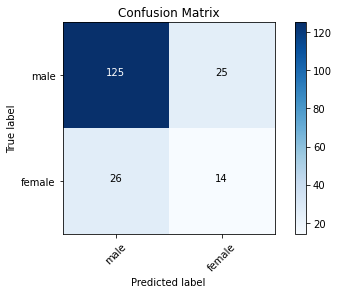

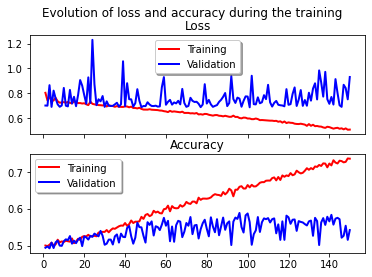

In [8]:
model = cnn_4()

history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=validation_split)

save_model(model, id)

accuracy, roc, f1_macro, f1_wei = test_1(model, X_test, y_test, id)

save_results(id, 'datatreat_A1', 'cnn_4', epochs, batch_size, accuracy, roc, f1_macro, f1_wei, validation_split)

plot_loss_acc_history(history, id, validation_split)